In [1]:
!pip install -q clu

In [2]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

In [3]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-05-09 13:47:49--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt.1'

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2024-05-09 13:47:49 (47.4 MB/s) - 'input.txt.1' saved [1115394/1115394]



In [4]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
data = jnp.array(encode(text), dtype=jnp.int32)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

(1115394,) int32
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1 39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39
 58 46 43 56  1 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47
 57 46 12  0  0 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53
 50 60 43 42  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47
 56 57 58  6  1 63 53 59  1 49 52 53 61  1 15 39 47 59 57  1 25 39 56 41
 47 59 57  1 47 57  1 41 46 47 43 44  1 43 52 43 51 63  1 58 53  1 58 46
 43  1 54 43 53 54 50 43  8  0  0 13 50 50 10  0 35 43  1 49 52 53 61  5
 58  6  1 61 43  1 49 52 53 61  5 58  8  0  0 18 47 56 57 58  1 15 47 58
 47 64 43 52 10  0 24 43 58  1 59 57  1 49 47 50 50  1 46 47 51  6  1 39
 52 42  1 61 43  5 50 50  1 46 39 

In [8]:
train_test_split = 0.9
n = int(train_test_split*len(data))
train_data = data[:n]
test_data = data[n:]

In [9]:
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [10]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [11]:
batch_size = 256 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128
expans = 2
n_head = 4
channel_size = n_embd // n_head
n_layers = 4
dropout = 0.2
conv_k_size = 3
n_latent_dim = 16

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + 1, (block_size,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

# print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context} the target: {target}")

inputs:
(256, 64)
[[ 6  1 61 ... 53 50 42]
 [21  1 42 ... 44 47 43]
 [58 46 43 ... 43 56 43]
 ...
 [ 6  0 13 ... 46 53 59]
 [45 56 39 ...  1 41 53]
 [ 1 51 43 ... 57 46 53]]
targets:
(256, 64)
[[ 1 61 46 ... 50 42  0]
 [ 1 42 47 ... 47 43 56]
 [46 43  1 ... 56 43  1]
 ...
 [ 0 13 52 ... 53 59 45]
 [56 39 41 ... 41 53 51]
 [51 43 52 ... 46 53 61]]


In [12]:
@dataclass
class ModelArgs: # The same as torch version since this does not have any torch specific code
    d_model: int
    n_layer: int
    vocab_size: int
    d_state: int = 16
    expand: int = 2
    dt_rank: Union[int, str] = 'auto'
    d_conv: int = 4 
    pad_vocab_size_multiple: int = 8
    conv_bias: bool = True
    bias: bool = False
    
    def __post_init__(self):
        self.d_inner = int(self.expand * self.d_model)
        
        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)
            
        if self.vocab_size % self.pad_vocab_size_multiple != 0:
            self.vocab_size += (self.pad_vocab_size_multiple
                                - self.vocab_size % self.pad_vocab_size_multiple)

In [13]:
class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight', nn.initializers.ones, (self.d_model,)) # TODO, maybe use setup will be more clear
        normed = x * jax.lax.rsqrt(np.mean(np.square(x), axis=-1, keepdims=True) + self.eps)
        output = normed * weight
        return output

In [14]:
xb.shape

(256, 64)

In [15]:
class Expan_proj(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=n_embd)(x)
        return x
    
in_proj = nn.Dense(features=n_embd)
params = in_proj.init(rng_key, xb)
in_proj.apply(params, xb).shape

(256, 128)

In [16]:
jax.tree_util.tree_map(lambda x: x.shape, params)

{'params': {'bias': (128,), 'kernel': (64, 128)}}

# Mamba Block
Dense --> Conv1D --> Silu --> SSM --> Silu --> 

In [17]:
class MambaBlock(nn.Module):
    
    def setup(self):          
        self.in_proj1 = nn.Dense(features=n_embd * expans)
        self.in_proj2 = nn.Dense(features=n_embd * expans)
        
        # Adjusted for Flax. Flax does not have nn.Conv1d, so you might need to reshape or use a different approach
        self.conv1d = nn.Conv(features=n_embd * expans,
                              kernel_size=conv_k_size,
                              padding=1,
                              )

        self.A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, n_embd * expans, 1))
        self.B = self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, block_size))
        self.C = self.param('C', jax.random.normal, (1, n_latent_dim, 1, block_size))
#         self.D = self.param('D', jax.random.normal, (1, self.args.d_state, self.args.d_model, 1))
        self.delta = self.param('delta', jax.random.normal, (1, 1, n_embd * expans, block_size))
        
        self.out_proj = nn.Dense(n_embd)
        
        self.rms_norm = nn.RMSNorm()
        
    def __call__(self, x):
        
        embeds = x
        x = self.in_proj1(embeds)
        x = self.conv1d(x)
        x = jax.nn.silu(x)
        x = x.reshape((x.shape[0],1,x.shape[2],x.shape[1]))
        x = self.ssm(x)[1]
        x = x.reshape((x.shape[0],x.shape[3],x.shape[2]))
        x = x*jax.nn.silu(self.in_proj2(embeds))

        x = self.out_proj(x)
        
        x = self.rms_norm(x)
        
        return x
    def discretize(self):
        da = self.delta * self.A
        a_ = jnp.exp(da)
        b_ = self.C * self.delta
        return a_, b_

    def ssm(self, x):
        y = []
        h = 0
        a_, b_ = self.discretize()
        for k in range(x.shape[-1]):
            h = a_[..., k] * h + b_[..., k] * x[..., k]
            y.append((self.C[..., k] * h).sum(1, keepdims=True))
        return h, jnp.stack(y, -1)

In [18]:
# model = MambaBlock()
# params = model.init(jax.random.key(0), xb)
# print(model.tabulate(jax.random.key(0), xb,
#                    compute_flops=True, compute_vjp_flops=True))
# xs = model.apply(params, xb)
# xb.shape, xs.shape

In [19]:
xbs = jax.nn.one_hot(xb, vocab_size)
xbs.shape

(256, 64, 65)

In [20]:
class Mamba(nn.Module):
    
    def setup(self):
        self.embeddings = nn.Embed(vocab_size, n_embd)
        
        self.mamba_layers = [MambaBlock() for _ in range(n_layers)]
        
    def __call__(self, x):
        x = self.embeddings(x)
        
        for layer in self.mamba_layers:
            x = layer(x)
            
        out = self.embeddings.attend(x)
        return out
    
    @jax.jit
    def generate(self, idx, max_new_tokens, params):
    # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self.apply(params, idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            ##probs = tf.keras.activations.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = jax.random.categorical(jax.random.PRNGKey(52), logits) # (B, 1)
            # append sampled index to the running sequence
            idx = jax.numpy.expand_dims(jnp.concatenate([idx[0], idx_next], axis=0), 0) # (B, T+1)
    #         print(idx_next)
    #         print(idx)

        return idx    

In [21]:
fin_model = Mamba()
fin_params = fin_model.init(jax.random.key(42), xb)
n_params = sum(p.size for p in jax.tree_util.tree_leaves(fin_params))
print(f"Total number of parameters: {n_params:_}")
# print(fin_model.tabulate(jax.random.key(42), xb,
#                    compute_flops=True, compute_vjp_flops=True))
xf = fin_model.apply(fin_params, xb)
xb.shape, xf.shape

Total number of parameters: 1_282_176


((256, 64), (256, 64, 65))

In [22]:
# token_gen = generate(jnp.zeros((1,1)).astype(jnp.int32), 100, fin_model, fin_params)
# print(token_gen)
# print(decode(token_gen[0].tolist()))

In [23]:
jax.random.categorical(jax.random.PRNGKey(5332), 1000.0*xf[1][-1][:])

Array(64, dtype=int32)

In [24]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [25]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, train_shape):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones(train_shape).astype(jnp.int32))['params'] # initialize parameters by passing a template image
    tx = optax.adamw(learning_rate)
    return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty(),
    )

In [26]:
@jax.jit
def train_step(state, inputs, targets):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [27]:
@jax.jit
def compute_metrics(*, state, inputs, targets):
    logits = state.apply_fn({'params': state.params}, inputs)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=targets).mean()
    metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=targets, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [28]:
num_epochs = 10
learning_rate = 0.005
init_rng = jax.random.key(0)

In [29]:
state = create_train_state(fin_model, init_rng, learning_rate, train_shape)
del init_rng  # Must not be used anymore.

In [30]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [31]:
SEED = 442
key = jax.random.PRNGKey(SEED)
for step in tqdm(range(max_iters)): # increase number of steps for good results... 
    
      # sample a batch of data
    xb, yb = get_batch(key, train_data)
    state = train_step(state, xb, yb)
    state = compute_metrics(state=state, inputs=xb, targets=yb)
    
    key = (jax.random.split(key)[0])
    
    if (step+1) % 100 == 0: # one training epoch has passed
        for metric,value in state.metrics.compute().items(): # compute metrics
            metrics_history[f'train_{metric}'].append(value) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

        # Compute metrics on the test set after each training epoch
        test_state = state
        x_test, y_test = get_batch(key, test_data)
    #     for test_batch in test_ds.as_numpy_iterator():
        test_state = compute_metrics(state=test_state, inputs=x_test, targets=y_test)

        for metric,value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print(f"train epoch: {(step+1)}, "
              f"loss: {metrics_history['train_loss'][-1]}, "
              f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) }, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")    

  2%|▏         | 105/5000 [01:36<12:04,  6.76it/s]  

train epoch: 100, loss: 3.2463483810424805, accuracy: 18.05828857421875
test epoch: 100, loss: 2.9930901527404785, accuracy: 23.333740234375


  4%|▍         | 205/5000 [01:51<10:28,  7.62it/s]

train epoch: 200, loss: 2.545640230178833, accuracy: 33.30126953125
test epoch: 200, loss: 2.2800989151000977, accuracy: 40.557861328125


  6%|▌         | 305/5000 [02:06<10:24,  7.52it/s]

train epoch: 300, loss: 1.8739854097366333, accuracy: 50.23345947265625
test epoch: 300, loss: 1.739431381225586, accuracy: 54.095458984375


  8%|▊         | 405/5000 [02:22<10:04,  7.60it/s]

train epoch: 400, loss: 1.4221409559249878, accuracy: 61.7098388671875
test epoch: 400, loss: 1.2950432300567627, accuracy: 64.75830078125


 10%|█         | 505/5000 [02:37<09:45,  7.68it/s]

train epoch: 500, loss: 1.0805491209030151, accuracy: 70.70361328125
test epoch: 500, loss: 1.0064973831176758, accuracy: 72.821044921875


 12%|█▏        | 605/5000 [02:52<09:33,  7.67it/s]

train epoch: 600, loss: 0.9868355989456177, accuracy: 73.4599609375
test epoch: 600, loss: 1.0731093883514404, accuracy: 71.17919921875


 14%|█▍        | 705/5000 [03:07<09:18,  7.69it/s]

train epoch: 700, loss: 0.7943820953369141, accuracy: 78.3160400390625
test epoch: 700, loss: 0.7223230600357056, accuracy: 80.010986328125


 16%|█▌        | 805/5000 [03:22<09:11,  7.61it/s]

train epoch: 800, loss: 0.717648983001709, accuracy: 81.00970458984375
test epoch: 800, loss: 1.385572910308838, accuracy: 65.460205078125


 18%|█▊        | 905/5000 [03:37<08:57,  7.61it/s]

train epoch: 900, loss: 0.8500916957855225, accuracy: 77.24359130859375
test epoch: 900, loss: 0.6580053567886353, accuracy: 82.379150390625


 20%|██        | 1005/5000 [03:52<08:41,  7.66it/s]

train epoch: 1000, loss: 0.5766898393630981, accuracy: 84.65721893310547
test epoch: 1000, loss: 0.5651875734329224, accuracy: 84.89990234375


 22%|██▏       | 1105/5000 [04:07<08:31,  7.61it/s]

train epoch: 1100, loss: 0.5213892459869385, accuracy: 86.0726318359375
test epoch: 1100, loss: 0.5464465618133545, accuracy: 84.87548828125


 24%|██▍       | 1205/5000 [04:22<08:14,  7.67it/s]

train epoch: 1200, loss: 0.5254493951797485, accuracy: 85.9566650390625
test epoch: 1200, loss: 0.4673524498939514, accuracy: 87.188720703125


 26%|██▌       | 1305/5000 [04:38<08:01,  7.67it/s]

train epoch: 1300, loss: 0.36292585730552673, accuracy: 90.20654296875
test epoch: 1300, loss: 0.33845874667167664, accuracy: 90.6982421875


 28%|██▊       | 1405/5000 [04:53<07:49,  7.66it/s]

train epoch: 1400, loss: 0.3889438509941101, accuracy: 89.89068603515625
test epoch: 1400, loss: 0.3812914788722992, accuracy: 89.837646484375


 30%|███       | 1505/5000 [05:08<07:35,  7.67it/s]

train epoch: 1500, loss: 0.3415108919143677, accuracy: 90.85748291015625
test epoch: 1500, loss: 0.34156888723373413, accuracy: 90.899658203125


 32%|███▏      | 1605/5000 [05:23<07:24,  7.64it/s]

train epoch: 1600, loss: 0.3073422908782959, accuracy: 91.66766357421875
test epoch: 1600, loss: 0.2991156578063965, accuracy: 91.876220703125


 34%|███▍      | 1705/5000 [05:38<07:11,  7.63it/s]

train epoch: 1700, loss: 0.3223561644554138, accuracy: 91.699462890625
test epoch: 1700, loss: 0.3735741376876831, accuracy: 89.697265625


 36%|███▌      | 1805/5000 [05:53<06:58,  7.63it/s]

train epoch: 1800, loss: 0.30632978677749634, accuracy: 91.89263916015625
test epoch: 1800, loss: 0.35225600004196167, accuracy: 90.435791015625


 38%|███▊      | 1905/5000 [06:08<06:44,  7.65it/s]

train epoch: 1900, loss: 0.23794130980968475, accuracy: 93.72747802734375
test epoch: 1900, loss: 0.4123269319534302, accuracy: 92.49267578125


 40%|████      | 2005/5000 [06:23<06:31,  7.65it/s]

train epoch: 2000, loss: 0.25569722056388855, accuracy: 93.2017822265625
test epoch: 2000, loss: 0.24612194299697876, accuracy: 93.304443359375


 42%|████▏     | 2105/5000 [06:38<06:19,  7.64it/s]

train epoch: 2100, loss: 0.23740248382091522, accuracy: 93.68206787109375
test epoch: 2100, loss: 0.30025357007980347, accuracy: 91.76025390625


 44%|████▍     | 2205/5000 [06:53<06:05,  7.65it/s]

train epoch: 2200, loss: 0.21340566873550415, accuracy: 94.146240234375
test epoch: 2200, loss: 0.21148867905139923, accuracy: 94.110107421875


 46%|████▌     | 2305/5000 [07:09<05:53,  7.63it/s]

train epoch: 2300, loss: 0.27785661816596985, accuracy: 93.05614471435547
test epoch: 2300, loss: 0.7668060064315796, accuracy: 81.744384765625


 48%|████▊     | 2405/5000 [07:24<05:39,  7.64it/s]

train epoch: 2400, loss: 0.3963894546031952, accuracy: 89.38970947265625
test epoch: 2400, loss: 0.24928921461105347, accuracy: 93.133544921875


 50%|█████     | 2505/5000 [07:39<05:26,  7.64it/s]

train epoch: 2500, loss: 0.20589666068553925, accuracy: 94.4052734375
test epoch: 2500, loss: 0.20970489084720612, accuracy: 94.17724609375


 52%|█████▏    | 2605/5000 [07:54<05:12,  7.67it/s]

train epoch: 2600, loss: 0.20761790871620178, accuracy: 94.42962646484375
test epoch: 2600, loss: 0.3846965432167053, accuracy: 90.045166015625


 54%|█████▍    | 2705/5000 [08:09<04:59,  7.66it/s]

train epoch: 2700, loss: 0.2339101880788803, accuracy: 93.7137451171875
test epoch: 2700, loss: 0.20940077304840088, accuracy: 94.024658203125


 56%|█████▌    | 2805/5000 [08:24<04:47,  7.63it/s]

train epoch: 2800, loss: 0.722249448299408, accuracy: 83.51915740966797
test epoch: 2800, loss: 0.44289037585258484, accuracy: 88.055419921875


 58%|█████▊    | 2905/5000 [08:39<04:34,  7.64it/s]

train epoch: 2900, loss: 0.36330223083496094, accuracy: 90.4849853515625
test epoch: 2900, loss: 0.3217627704143524, accuracy: 91.4306640625


 60%|██████    | 3005/5000 [08:54<04:21,  7.64it/s]

train epoch: 3000, loss: 0.29797253012657166, accuracy: 92.00140380859375
test epoch: 3000, loss: 0.3074963688850403, accuracy: 91.717529296875


 62%|██████▏   | 3105/5000 [09:09<04:08,  7.64it/s]

train epoch: 3100, loss: 0.3099093437194824, accuracy: 91.71380615234375
test epoch: 3100, loss: 0.3208352327346802, accuracy: 91.259765625


 64%|██████▍   | 3205/5000 [09:25<03:54,  7.65it/s]

train epoch: 3200, loss: 0.38200464844703674, accuracy: 90.74803924560547
test epoch: 3200, loss: 0.7921933531761169, accuracy: 83.80126953125


 66%|██████▌   | 3305/5000 [09:40<03:40,  7.67it/s]

train epoch: 3300, loss: 0.558812141418457, accuracy: 86.1158447265625
test epoch: 3300, loss: 0.42226672172546387, accuracy: 88.824462890625


 68%|██████▊   | 3405/5000 [09:55<03:28,  7.63it/s]

train epoch: 3400, loss: 0.38790106773376465, accuracy: 89.76312255859375
test epoch: 3400, loss: 0.48400193452835083, accuracy: 87.53662109375


 70%|███████   | 3505/5000 [10:10<03:15,  7.65it/s]

train epoch: 3500, loss: 0.3532605767250061, accuracy: 90.52574920654297
test epoch: 3500, loss: 0.3187583088874817, accuracy: 91.39404296875


 72%|███████▏  | 3605/5000 [10:25<03:02,  7.63it/s]

train epoch: 3600, loss: 0.2955508232116699, accuracy: 92.0286865234375
test epoch: 3600, loss: 0.2927182614803314, accuracy: 92.138671875


 74%|███████▍  | 3705/5000 [10:40<02:48,  7.67it/s]

train epoch: 3700, loss: 0.2740353047847748, accuracy: 92.59521484375
test epoch: 3700, loss: 0.4386134743690491, accuracy: 91.40625


 76%|███████▌  | 3805/5000 [10:55<02:36,  7.63it/s]

train epoch: 3800, loss: 0.35887596011161804, accuracy: 91.21844482421875
test epoch: 3800, loss: 0.38592299818992615, accuracy: 90.00244140625


 78%|███████▊  | 3905/5000 [11:10<02:23,  7.66it/s]

train epoch: 3900, loss: 0.36065730452537537, accuracy: 90.47918701171875
test epoch: 3900, loss: 0.3370239734649658, accuracy: 90.936279296875


 80%|████████  | 4005/5000 [11:26<02:10,  7.63it/s]

train epoch: 4000, loss: 0.4080774486064911, accuracy: 89.42352294921875
test epoch: 4000, loss: 0.3137509822845459, accuracy: 91.44287109375


 82%|████████▏ | 4105/5000 [11:41<01:56,  7.66it/s]

train epoch: 4100, loss: 0.30309534072875977, accuracy: 91.86901092529297
test epoch: 4100, loss: 0.295218825340271, accuracy: 92.169189453125


 84%|████████▍ | 4205/5000 [11:56<01:43,  7.66it/s]

train epoch: 4200, loss: 0.28291189670562744, accuracy: 92.42584228515625
test epoch: 4200, loss: 0.2663920819759369, accuracy: 92.76123046875


 86%|████████▌ | 4305/5000 [12:11<01:31,  7.63it/s]

train epoch: 4300, loss: 0.24104337394237518, accuracy: 93.547607421875
test epoch: 4300, loss: 0.2615779936313629, accuracy: 92.987060546875


 88%|████████▊ | 4405/5000 [12:26<01:17,  7.63it/s]

train epoch: 4400, loss: 0.2220408022403717, accuracy: 93.91888427734375
test epoch: 4400, loss: 0.23572158813476562, accuracy: 93.499755859375


 90%|█████████ | 4505/5000 [12:41<01:04,  7.64it/s]

train epoch: 4500, loss: 0.24298252165317535, accuracy: 93.56529998779297
test epoch: 4500, loss: 0.3036889433860779, accuracy: 91.839599609375


 92%|█████████▏| 4605/5000 [12:56<00:51,  7.64it/s]

train epoch: 4600, loss: 0.25274720788002014, accuracy: 93.243896484375
test epoch: 4600, loss: 0.2649381756782532, accuracy: 92.7490234375


 94%|█████████▍| 4705/5000 [13:11<00:38,  7.64it/s]

train epoch: 4700, loss: 0.34963706135749817, accuracy: 91.49346923828125
test epoch: 4700, loss: 0.2907612919807434, accuracy: 91.925048828125


 96%|█████████▌| 4805/5000 [13:27<00:25,  7.64it/s]

train epoch: 4800, loss: 0.2646918296813965, accuracy: 92.8525390625
test epoch: 4800, loss: 0.28040003776550293, accuracy: 92.5048828125


 98%|█████████▊| 4905/5000 [13:42<00:12,  7.65it/s]

train epoch: 4900, loss: 0.25252750515937805, accuracy: 93.154296875
test epoch: 4900, loss: 0.25054216384887695, accuracy: 93.133544921875


100%|██████████| 5000/5000 [13:57<00:00,  5.97it/s]

train epoch: 5000, loss: 0.24565507471561432, accuracy: 93.32726287841797
test epoch: 5000, loss: 0.28196126222610474, accuracy: 92.3095703125


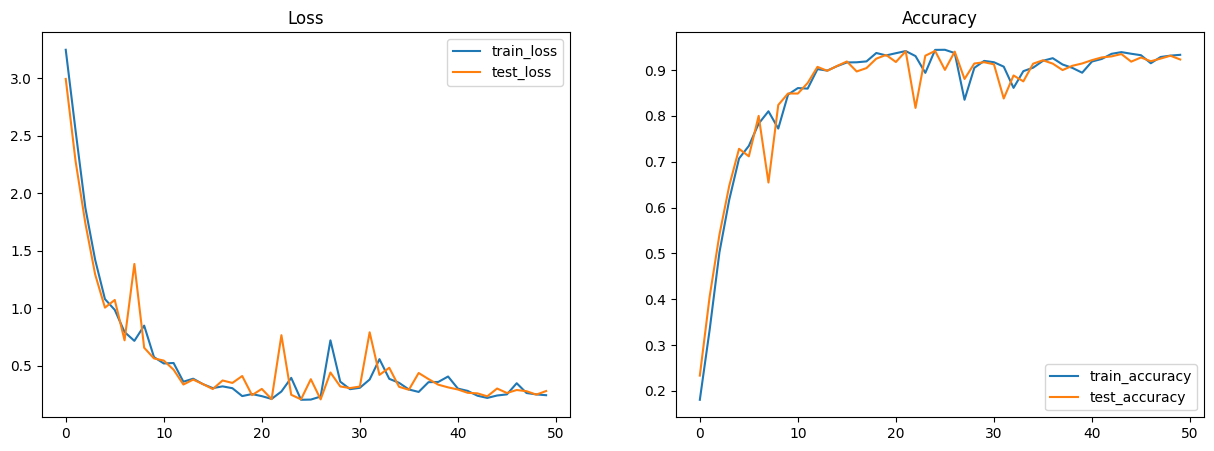

<Figure size 640x480 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [33]:

logits = fin_model.apply(fin_params, xb)
loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=yb).mean()

print(loss)

4.690998


In [34]:
def generate_text(idx, max_new_tokens, params):
# idx is (B, T) array of indices in the current context
    for i in range(max_new_tokens):
        # crop idx to the last block_size tokens
        idx_cond = idx[:, -block_size:]
        # get the predictions
        logits = fin_model.apply(params, idx_cond)
        # focus only on the last time step
        logits = logits[:, -1, :] # becomes (B, C)

        if i == 0:
            rng, rng_subkey = jax.random.split(jax.random.PRNGKey(12))
        else:
            rng, rng_subkey = jax.random.split(rng)
            
        idx_next = jax.random.categorical(rng_subkey, logits, axis=-1, shape=(1, 1)) # (B, 1)

        
        # append sampled index to the running sequence
        idx = jnp.concatenate([idx, idx_next], axis=-1) # (B, T+1)

    return idx    

In [35]:
new_tokenz = 1000
token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
print(token_gen)
print(decode(token_gen[0].tolist()))

[[ 0  0  0 ... 46 43 52]]
































































Mes kimenem soy woo segorborty.
Gon reh hezaf'cht womyxy leiyke the he.! theete thederam, youpuch both nih, mellly gir wenfeer pice ska, thh-E:
CSon gre an geo yon eand wid u of I soringiilk Myghind?

TIUOF ILLRAPOET:
Thill
If tling ith wighe.
Burd the,
Auhy Raikfuctes, pupalusping bam I Men'd wastrze cey a dearpaejt lam-staisime coury thze kich thembe.n faw Iiche wo darecfrierdhe thin they saligh ormim holl ad weti wilk's? thou gor, weaveoomay obew vavergasfurd ye how:
Vowgle cingaffis carto, shenandoshis veum nour.

Dw: wionce enn!
Nom,
theorledot .ory is bund thof handosterg hion hor of jour Ay Swice Wei.

SISDTOUWowidbe ped? me tortekd-sand doth yith my wighald vy r fegroh weanet of meyaffache and fy I chiveo jid yoush dimu is pale wit; his  ved wed: gift henrn indssh ladhye, his doths
Iutiovaye cow witeasw hoive-e ces; in wom's wethon unT qiortrg cat of fade woldy Orr pu,
Eim oll
To not no fo

In [36]:
xbb, ybb = get_batch(key, test_data)
logits = state.apply_fn({'params': state.params}, xbb[3].reshape(1,32))[:,-1,:]
token_genz = jax.random.categorical(rng_subkey, logits, axis=-1, shape=(1, 1))
print(token_genz)
print("gen text: ",print(decode([int(token_genz[0])])), "end of text")
ybb[0]

TypeError: cannot reshape array of shape (64,) (size 64) into shape (1, 32) (size 32)

In [ ]:
jax.random.categorical(jax.random.PRNGKey(100), jnp.array([10.0,-10.0,-10.0,10.0,-11.0,-11.0,-11.0,-100.0,-1000]))

In [ ]:
logitss = state.apply_fn({'params': state.params}, (43*jnp.zeros((1,1))).astype(jnp.int32))[:,-1,:]

In [ ]:
token_gen[:,-32:]

In [ ]:
print("gen text: ",print(decode(token_gen[0].tolist())), "end of text")

In [ ]:
jax.random.randint(jax.random.PRNGKey(52), (1,32), minval, maxval

In [ ]:
import torch
from torch.nn import functional as F
import numpy as np

logitss = state.apply_fn({'params': state.params}, xbb[0].reshape(1,32))[:,-1,:]

probs = F.softmax(torch.from_numpy(np.asarray(logitss)), dim=-1) # (B, C)
# sample from the distribution
idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
idx_next